In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from astropy import stats
from skimage.transform import resize
from scipy.ndimage import rotate 
import sys
import time
from IPython import display

In [2]:
filaments = r'C:\Users\shari\Documents\YR 4 Project\My work\sim_filaments.npy'
not_filaments = r'C:\Users\shari\Documents\YR 4 Project\My work\sim_notfilaments.npy'

In [3]:
fil = np.load(filaments, allow_pickle = True)
n_fil = np.load(not_filaments, allow_pickle = True)

In [4]:
labels_fil = np.full(len(fil), 1)
labels_nfil = np.zeros(len(n_fil))

In [5]:
images = np.concatenate((fil,n_fil))
labels = np.concatenate((labels_fil,labels_nfil))

In [6]:
sigma = 1
for i in range(len(images)):
    mean, median, std = stats.sigma_clipped_stats(images[i], sigma=sigma)
    images[i][images[i] < median+sigma*std] = median+sigma*std

In [7]:
for i in range(len(images)):
    images[i] = 2*(images[i]-np.min(images[i]))/np.ptp(images[i])-1

1.0 4.059971323795045e-05


In [8]:
print(np.max(images), np.min(images))

In [9]:
shuffle = np.random.permutation(range(len(images)))
images = images[shuffle]
labels = labels[shuffle]

In [10]:
n = 24
def show_images(images, num=n):
    cols = 6
    rows = (num+cols-1)//cols
    plt.figure(figsize=(n,3*rows))
    for i in range(num):
        ax = plt.subplot(rows, cols, i+1)
        image = images[i] ##randomise where i starts from 
        plt.title(labels[i])
        plt.imshow(image, cmap='inferno')
        plt.axis('off')
    plt.show()

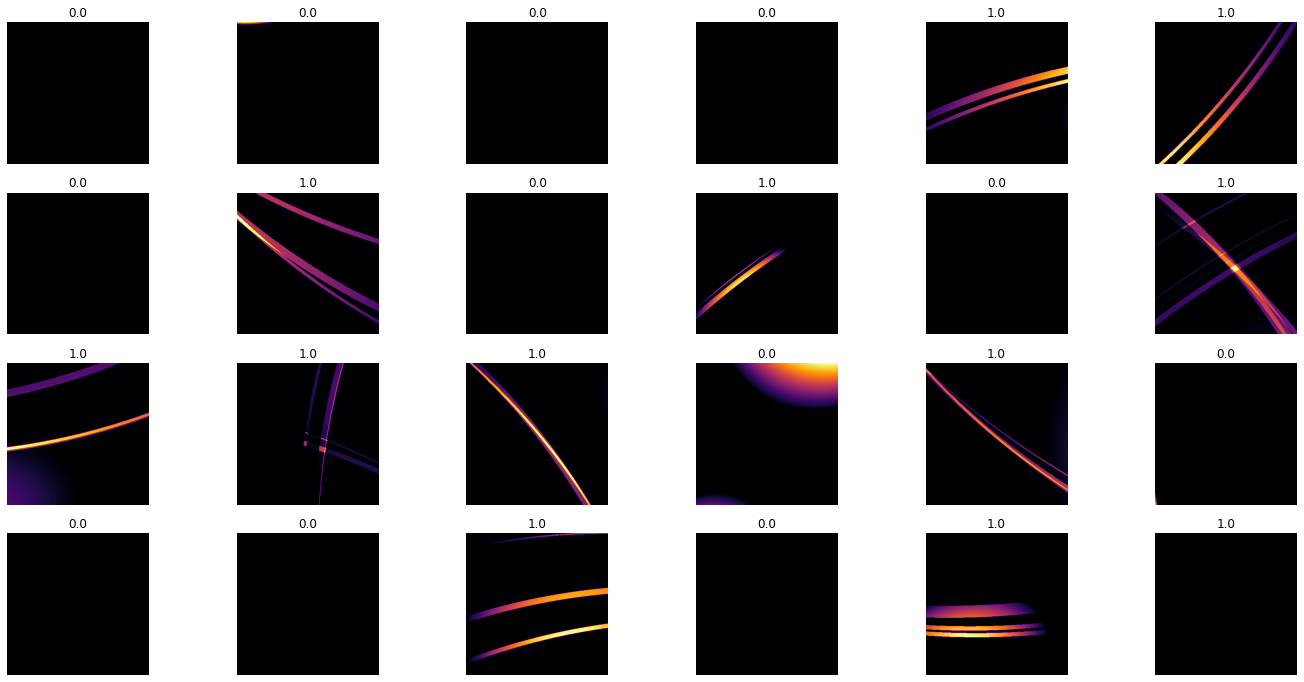

In [13]:
show_images(images)

In [25]:
percentage_train = 0.8
batch_size = 32
epochs = 20

num_train = int(np.round(len(images)*percentage_train))
train_images, test_images = np.split(images, [num_train])
train_labels, test_labels = np.split(labels, [num_train])

In [26]:
train_images = train_images[..., tf.newaxis].astype('float32')
test_images = test_images[..., tf.newaxis].astype('float32')

In [27]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

In [28]:
print('train images: ', train_images.shape)
print('test images: ', test_images.shape)

train images:  (1600, 400, 400, 1)
test images:  (400, 400, 400, 1)


In [29]:
input_shape = train_images.shape[1:]

# Alhassan model
model = models.Sequential([
    layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(194, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_ds.batch(batch_size), validation_data=test_ds.batch(batch_size), epochs=epochs)
model.evaluate(test_ds.batch(32), verbose=2)

Epoch 1/20
50/50 [==============================] - 92s 2s/step - loss: 1.4263 - accuracy: 0.5813 - val_loss: 1.5137 - val_accuracy: 0.4725
Epoch 2/20
50/50 [==============================] - 86s 2s/step - loss: 0.6305 - accuracy: 0.6952 - val_loss: 0.4273 - val_accuracy: 0.8575
Epoch 3/20
50/50 [==============================] - 87s 2s/step - loss: 0.3638 - accuracy: 0.8597 - val_loss: 0.3215 - val_accuracy: 0.8750
Epoch 4/20
50/50 [==============================] - 85s 2s/step - loss: 0.3908 - accuracy: 0.8070 - val_loss: 0.4343 - val_accuracy: 0.8000
Epoch 5/20
50/50 [==============================] - 90s 2s/step - loss: 0.4660 - accuracy: 0.7760 - val_loss: 0.3039 - val_accuracy: 0.8450
Epoch 6/20
50/50 [==============================] - 93s 2s/step - loss: 0.3261 - accuracy: 0.8575 - val_loss: 0.2305 - val_accuracy: 0.8800
Epoch 7/20
50/50 [==============================] - 89s 2s/step - loss: 0.3365 - accuracy: 0.8580 - val_loss: 0.2292 - val_accuracy: 0.9100
Epoch 8/20
50/50 [==

[0.14592526853084564, 0.9649999737739563]

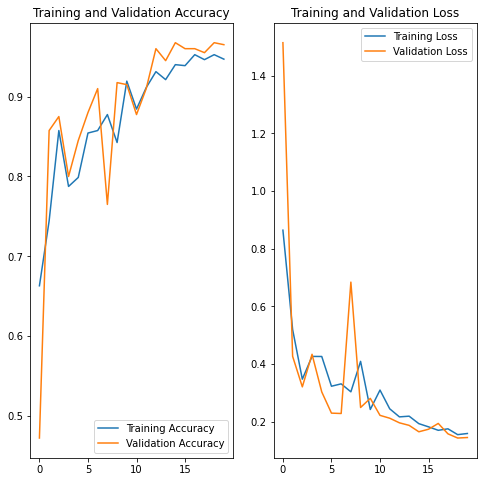

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

plt.savefig('SIM CNN Results.png')

In [31]:
test_predictions = model.predict(test_images)
test_predictions = np.squeeze(test_predictions)

In [32]:
num = 24

def show_image_predictions(images, labels, predictions):
    
    cols = 6
    rows = (num+cols-1)//cols
    plt.figure(figsize=(n,3*rows))
    
    for i in range(num):
        ax = plt.subplot(rows, cols, i+1)
        image = images[i]
        plt.imshow(image, cmap='inferno')
        plt.title('{}, {}'.format(predictions[i], labels[i]))
        plt.axis('off')
    plt.show()


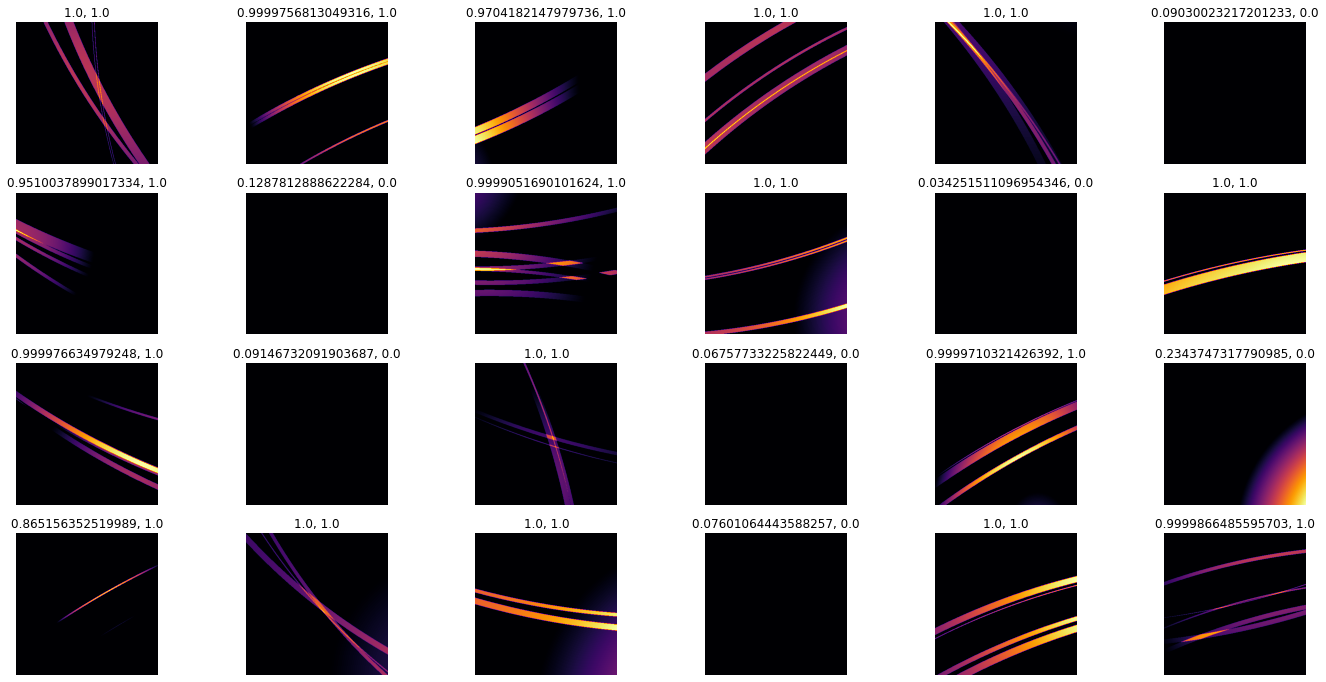

In [33]:
show_image_predictions(test_images, test_labels, test_predictions)